<a href="https://colab.research.google.com/github/curtiscu/LYIT/blob/master/BeatTrackingTests_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Work out beats, timings, etc for loaded data

Doc that came in handy creating this notebook..

* https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab
* https://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
* https://switowski.com/blog/ipython-autoreload


# Setup env


In [1]:
# print all cell output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# install required libs
!pip install mido


In [2]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# test, peek at data
! ls -al '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/'

# test, modules from local  'E:\Google Drive\LYIT\Dissertation\modules'
! ls -al '/content/drive/My Drive/LYIT/Dissertation/modules/'

total 35
-rw------- 1 root root 2589 Apr 27 12:01 10_soul-groove10_102_beat_4-4.mid
-rw------- 1 root root 4793 Apr 27 12:01 1_funk-groove1_138_beat_4-4.mid
-rw------- 1 root root 3243 Apr 27 12:01 2_funk-groove2_105_beat_4-4.mid
-rw------- 1 root root 4466 Apr 27 12:01 3_soul-groove3_86_beat_4-4.mid
-rw------- 1 root root 2551 Apr 27 12:01 4_soul-groove4_80_beat_4-4.mid
-rw------- 1 root root 3798 Apr 27 12:01 5_funk-groove5_84_beat_4-4.mid
-rw------- 1 root root 3760 Apr 27 12:01 6_hiphop-groove6_87_beat_4-4.mid
-rw------- 1 root root 1894 Apr 27 12:01 7_pop-groove7_138_beat_4-4.mid
-rw------- 1 root root 2437 Apr 27 12:01 8_rock-groove8_65_beat_4-4.mid
-rw------- 1 root root 3448 Apr 27 12:01 9_soul-groove9_105_beat_4-4.mid
total 15
-rw------- 1 root root 10781 May 13 18:11 data_prep.py
drwx------ 2 root root  4096 May 10 13:31 __pycache__


## Auto reload module

I'm now using a module edited and saved to google drive which is automatically pushed to the cloud and made available to the colab env. Changes need time to propagate, and imports don't 'reimport' to load changes, so trying the following...

Note the code below is not very reliable, it seems to work occasionally, after some time, but haven't been able to work out the pattern to it. 

If in a hurry, brute force loading of changes by restarting the runtime.

In [0]:
# tool to auto reload modules.
%load_ext autoreload

# config to auto-reload all modules, handy to make 
# writing and testing modules much easier.
%autoreload 2

In [5]:
# imports
import pandas as pd
import mido 
from mido import MidiFile

import datetime

import math

# import my modules
import sys
sys.path.append('/content/drive/My Drive/LYIT/Dissertation/modules/')
import data_prep



LOADING - data_prep.py module name is: data_prep


In [6]:
print(datetime.datetime.now())

2020-05-14 15:11:26.688942


In [7]:
# testing auto reload of modules 
data_prep.test_function_call('bling')

test function called worked! :)  bling


In [0]:
def set_pandas_display_options() -> None:
    # Ref: https://stackoverflow.com/a/52432757/
    display = pd.options.display

    display.max_columns = 1000
    display.max_rows = 200
    display.max_colwidth = 1000
    display.width = None
    # display.precision = 2  # set as needed

set_pandas_display_options()
#pd.reset_option('all')


# Test creating object from custom module

In [9]:
file_name = '/content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/10_soul-groove10_102_beat_4-4.mid'
gmt = data_prep.GrooveMidiTools
midi_file = data_prep.MIDI_File_Wrapper(file_name, gmt.mappings)

FILE: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/10_soul-groove10_102_beat_4-4.mid
    tracks: [<midi track 'MIDI' 639 messages>]
    time sig: <meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
    tempo: <meta message set_tempo tempo=588235 time=0>
    good instruments: 6, {36.0: 'Bass Drum 1', 38.0: 'Acoustic Snare', 42.0: 'Closed Hi Hat', 43.0: 'High Floor Tom', 46.0: 'Open Hi-Hat', 50.0: 'High Tom'}


... the above verifies I'm able to create custom objects from custom code, great!


# Brainstorming ways to calculate beat times

Things I might need to calculate..
* start/ end times of bars
* beat times for 1/4, 1/8, 1/16, 1/32 notes
* shuffles in 4/4?

Ways to go about it...
* Take list of MIDI note_on, find what beat & bar to associate each beat with.
* For a given musical beat, take the acceptable timing range for something to be considered related to it, filter all the MIDI notes against this range to see which if any fall into that range.

Python code/ libs for ranges and splitting datasets..
* python 'range', only works on integers
* pandas.cut, pandas.qcut
* numpy
* itertools 

Some handy refs...
* https://realpython.com/how-to-use-numpy-arange/
* https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
* https://pbpython.com/pandas-qcut-cut.html < looks very promising!!!


## peek at example object data..

In [10]:
# take a peek inside what we've setup already...
midi_file.__dict__

{'df_midi_data':             msg_type  delta_ticks  total_ticks  total_seconds  note  velocity  \
 0         track_name            0            0       0.000000   NaN       NaN   
 1    instrument_name            0            0       0.000000   NaN       NaN   
 2     time_signature            0            0       0.000000   NaN       NaN   
 3      key_signature            0            0       0.000000   NaN       NaN   
 4       smpte_offset            0            0       0.000000   NaN       NaN   
 ..               ...          ...          ...            ...   ...       ...   
 634          note_on           37        30566      37.458315  43.0     112.0   
 635         note_off           83        30649      37.560030  43.0      64.0   
 636          note_on           24        30673      37.589442  36.0     127.0   
 637         note_off           83        30756      37.691158  36.0      64.0   
 638     end_of_track            0        30756      37.691158   NaN       NaN   


In [11]:
midi_file.__doc__

'\n  Utility wrapper for loading, parsding a mido.MidiFile object\n  '

## Calulate some time metrics


In [12]:
print('file name: {}'.format(midi_file.my_file_name))
print('ticks per quarter note: {}'.format(midi_file.ticks()))
print('tempo (microseconds p/ quarter): {}'.format(midi_file.tempo_us()))
print('tempo (bpm): {}'.format(midi_file.tempo_bpm()))

file name: /content/drive/My Drive/groove-v1.0.0-midionly/groove/drummer1/eval_session/10_soul-groove10_102_beat_4-4.mid
ticks per quarter note: 480
tempo (microseconds p/ quarter): 588235
tempo (bpm): 102.0000510000255


In [13]:

def calc_sec(ticks):
  '''
  Utility function: given MIDI ticks, caluate absolute time in milliseconds
  '''
  # mido.tick2second(ticks, < ticks per quarter >, < tempo in microseconds> )
  return mido.tick2second(ticks, midi_file.ticks(), midi_file.tempo_us() )

print('seconds per tick (ticks2seconds): {}'.format(calc_sec(1)))

# NOTE: calculate microseconds per tick
# µs_per_tick  = quarter note tempo (microseconds) / ticks per qaurter beat 
us_per_tick =  midi_file.tempo_us()/ midi_file.ticks()
print('microseconds per tick: {}, rounded: {}'.format(us_per_tick, round(us_per_tick)))

# NOTE: the following works for different time sigs, i.e. 
#   will handle 6/8  and  4/4 ok...
# beat ticks = <ticks per quarter beat> x  ( 4/ < file time sig denominator > )
ticks_per_beat = midi_file.ticks() * ( 4/ midi_file.ts_denom() )
print('per beat: {}, ticks: {}, sec: {}'.format(midi_file.ts_denom(), ticks_per_beat, calc_sec(ticks_per_beat)))

# NOTE: total ticks for a measure..
# bar ticks = < beat ticks >  x < beats per bar >
ticks_per_bar = ticks_per_beat * midi_file.ts_num()
print('per bar - ticks: {}, sec: {}'.format(ticks_per_bar, calc_sec(ticks_per_bar)))

# Ticks per 1/8 note
ticks_per_8 = midi_file.ticks() * ( 4/ 8 )
print('per 1/8 - ticks: {}, sec: {}'.format(ticks_per_8, calc_sec(ticks_per_8)))

# Ticks per 1/16 note
ticks_per_16 = midi_file.ticks() * ( 4/ 16 )
print('per 1/16 - ticks: {}, sec: {}'.format(ticks_per_16, calc_sec(ticks_per_16)))


seconds per tick (ticks2seconds): 0.0012254895833333332
microseconds per tick: 1225.4895833333333, rounded: 1225
per beat: 4, ticks: 480.0, sec: 0.588235
per bar - ticks: 1920.0, sec: 2.35294
per 1/8 - ticks: 240.0, sec: 0.2941175
per 1/16 - ticks: 120.0, sec: 0.14705875


## Calculate number of bars in file 


In [14]:
# CALCULATE BARS USING TIMING INFO

# last note_on event in file, in seconds..
#    event# 636, time(s): 37.589442
# .. divided by length of bar in seconds
total_bars_using_time = 37.589442 /2.35294
print('number bars in file, calculated using time: {}'.format( total_bars_using_time))

number bars in file, calculated using time: 15.975520837760419


In [15]:
# round up number of bars
total_bars_using_time = math.ceil(total_bars_using_time)

print('# bars using calculated time, rounded up: {}'.format(total_bars_using_time))

# bars using calculated time, rounded up: 16


In [16]:
# CALCULATE BARS USING TICKS

# last 'note_on'= event:636, ticks:30673, seconds:37.589442
# total_bars_using_ticks = 30673/ ticks_per_bar

file_df = midi_file.df_midi_data
last_note_on = file_df[file_df[midi_file.type_col] == 'note_on'].tail(1)[midi_file.cum_ticks_col]
total_bars_using_ticks = last_note_on / ticks_per_bar

total_bars_using_ticks

636    15.975521
Name: total_ticks, dtype: float64

In [17]:
# round up number of bars
total_bars_using_ticks = math.ceil(total_bars_using_ticks)

print('# bars using MIDI ticks for calculation, rounded up: {}'.format(total_bars_using_ticks))

# bars using MIDI ticks for calculation, rounded up: 16


# Calculate number of beats in file

In [18]:
# number of beats in file
total_beats = total_bars_using_ticks * midi_file.ts_num()
print('total beatz MIDI file spans: {}'.format(total_beats))


total beatz MIDI file spans: 64


In [0]:
# for later in notebook
total_bars = total_bars_using_ticks

# Splitting data




## Testing pandas.cut

* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html


In [20]:
# example usage -> pd.cut(df['ext price'], bins=4)
display(pd.cut(midi_file.df_midi_data[midi_file.cum_ticks_col], bins=64).to_frame())

,total_ticks
0,"(-30.756, 480.562]"
1,"(-30.756, 480.562]"
2,"(-30.756, 480.562]"
3,"(-30.756, 480.562]"
4,"(-30.756, 480.562]"
...,...
634,"(30275.438, 30756.0]"
635,"(30275.438, 30756.0]"
636,"(30275.438, 30756.0]"
637,"(30275.438, 30756.0]"


There's a problem using pd.cut above, note the last bucket ends at precisely the last numbered tick, but the first bucket has a start that's a negative! Looks like it works by segmenting from the high number/ end of the data down, therefore ends up -ve.

I've also included the entire set of MIDI events from the file, I really only need to use the 'note_on' events.


Looks like there are additional params to 'cut' I can use to sort this out, more info here..
* https://stackoverflow.com/a/57041772
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

The above stack overflow link gives the following example..

`df['score_range'] = pd.cut(x=df['score'], bins=range(0, 125, 25), right=False)`

I need to pass in explicit list of bins to use, and this can be done using 'bins=range(< start >, < stop>, < interval>)' ...

* total_range = (ticks_per_beat x beats_per_bar x bars_in_file)
* bin size = ticks_per_beat_resolution



In [21]:
# set to quantize/ beat alignment resolution
ticks_per_beat_resolution = 120  # (i.e.  16th note = 480/4 )

file_range = int(ticks_per_beat * midi_file.ts_num() * total_bars)
bin_size = int(ticks_per_beat_resolution)

print('file_range: {}, bin_size: {}'.format(file_range, bin_size))

df = midi_file.df_midi_data  # shorten name
# just_ons = df[df['msg_type'] == 'note_on']  # filter 'note_on' events
just_ons = df  # debug, don't filter to ons, just to test

# if you don't 'file_range + bin_size' you get one short
my_bins=range(0, file_range + bin_size, bin_size)  

pd.cut(just_ons[midi_file.cum_ticks_col], bins=my_bins, right=False).to_frame()


file_range: 30720, bin_size: 120


,total_ticks
0,"[0.0, 120.0)"
1,"[0.0, 120.0)"
2,"[0.0, 120.0)"
3,"[0.0, 120.0)"
4,"[0.0, 120.0)"
...,...
634,"[30480.0, 30600.0)"
635,"[30600.0, 30720.0)"
636,"[30600.0, 30720.0)"
637,NaN


## Calculate bins


Recap...
* Calculated bin sizes are the size of our notes we're going to detect, i.e. 16th notes.

* Need to properly bin notes that are either early or late, to do this we assign notes to a bin that are up to half a bin/ note size early or late, so need to slide the window down by half a bin. This means we capture notes early/ late either side of the 16th note.

In [22]:
# recalcalculate bins sliding them down 
# by half a bin size...
print('halfa bin: {}'.format (bin_size/2))

my_bins=range(0 - (int(bin_size/ 2)), file_range + bin_size, bin_size)  # if you don't 'file_range + bin_size' you get one short
my_bins


halfa bin: 60.0


range(-60, 30840, 120)

In [23]:
calculated_bins = pd.cut(just_ons[midi_file.cum_ticks_col], bins=my_bins, right=False)
type(calculated_bins)
print(calculated_bins)

pandas.core.series.Series

0           [-60, 60)
1           [-60, 60)
2           [-60, 60)
3           [-60, 60)
4           [-60, 60)
            ...      
634    [30540, 30660)
635    [30540, 30660)
636    [30660, 30780)
637    [30660, 30780)
638    [30660, 30780)
Name: total_ticks, Length: 639, dtype: category
Categories (257, interval[int64]): [[-60, 60) < [60, 180) < [180, 300) < [300, 420) < ... <
                                    [30300, 30420) < [30420, 30540) < [30540, 30660) <
                                    [30660, 30780)]


In [24]:
beat_points = range(0, file_range + bin_size, bin_size)  # if you don't 'file_range + bin_size' you get one short
assigned_beat_location = pd.cut(just_ons[midi_file.cum_ticks_col], bins=my_bins, right=False, labels=beat_points)
assigned_beat_location


0          0
1          0
2          0
3          0
4          0
       ...  
634    30600
635    30600
636    30720
637    30720
638    30720
Name: total_ticks, Length: 639, dtype: category
Categories (257, int64): [0 < 120 < 240 < 360 ... 30360 < 30480 < 30600 < 30720]

In [0]:
# Track where in the timeline each MIDI event happened
# by adding calculted bin/ category as a new column
df['bin_cat'] = calculated_bins

# label events with nearest beat
df['beat_cat'] = assigned_beat_location


In [26]:
df.head(20)
df.tail(20)

,msg_type,delta_ticks,total_ticks,total_seconds,note,velocity,raw_data,bin_cat,beat_cat
0,track_name,0,0,0.000000,NaN,NaN,"{'type': 'track_name', 'name': 'MIDI', 'time': 0}","[-60, 60)",0
1,instrument_name,0,0,0.000000,NaN,NaN,"{'type': 'instrument_name', 'name': 'Brooklyn', 'time': 0}","[-60, 60)",0
2,time_signature,0,0,0.000000,NaN,NaN,"{'type': 'time_signature', 'numerator': 4, 'denominator': 4, 'clocks_per_click': 24, 'notated_32nd_notes_per_beat': 8, 'time': 0}","[-60, 60)",0
3,key_signature,0,0,0.000000,NaN,NaN,"{'type': 'key_signature', 'key': 'C', 'time': 0}","[-60, 60)",0
4,smpte_offset,0,0,0.000000,NaN,NaN,"{'type': 'smpte_offset', 'frame_rate': 24, 'hours': 33, 'minutes': 0, 'seconds': 0, 'frames': 0, 'sub_frames': 0, 'time': 0}","[-60, 60)",0
5,set_tempo,0,0,0.000000,NaN,NaN,"{'type': 'set_tempo', 'tempo': 588235, 'time': 0}","[-60, 60)",0
6,control_change,0,0,0.000000,NaN,NaN,"{'type': 'control_change', 'time': 0, 'control': 4, 'value': 90, 'channel': 9}","[-60, 60)",0
7,note_on,0,0,0.000000,42.0,99.0,"{'type': 'note_on', 'time': 0, 'note': 22, 'velocity': 99, 'channel': 9}","[-60, 60)",0
8,note_on,0,0,0.000000,36.0,127.0,"{'type': 'note_on', 'time': 0, 'note': 36, 'velocity': 127, 'channel': 9}","[-60, 60)",0
9,note_off,71,71,0.087010,42.0,64.0,"{'type': 'note_off', 'time': 71, 'note': 22, 'velocity': 64, 'channel': 9}","[60, 180)",120


,msg_type,delta_ticks,total_ticks,total_seconds,note,velocity,raw_data,bin_cat,beat_cat
619,note_on,7,30178,36.982825,42.0,62.0,"{'type': 'note_on', 'time': 7, 'note': 44, 'velocity': 62, 'channel': 9}","[30060, 30180)",30120
620,note_off,4,30182,36.987727,50.0,64.0,"{'type': 'note_off', 'time': 4, 'note': 48, 'velocity': 64, 'channel': 9}","[30180, 30300)",30240
621,control_change,21,30203,37.013462,NaN,NaN,"{'type': 'control_change', 'time': 21, 'control': 4, 'value': 90, 'channel': 9}","[30180, 30300)",30240
622,note_on,11,30214,37.026942,50.0,127.0,"{'type': 'note_on', 'time': 11, 'note': 48, 'velocity': 127, 'channel': 9}","[30180, 30300)",30240
623,note_off,46,30260,37.083315,42.0,64.0,"{'type': 'note_off', 'time': 46, 'note': 44, 'velocity': 64, 'channel': 9}","[30180, 30300)",30240
624,note_off,37,30297,37.128658,50.0,64.0,"{'type': 'note_off', 'time': 37, 'note': 48, 'velocity': 64, 'channel': 9}","[30180, 30300)",30240
625,note_on,33,30330,37.169099,43.0,96.0,"{'type': 'note_on', 'time': 33, 'note': 43, 'velocity': 96, 'channel': 9}","[30300, 30420)",30360
626,control_change,46,30376,37.225472,NaN,NaN,"{'type': 'control_change', 'time': 46, 'control': 4, 'value': 9, 'channel': 9}","[30300, 30420)",30360
627,note_off,36,30412,37.269589,43.0,64.0,"{'type': 'note_off', 'time': 36, 'note': 43, 'velocity': 64, 'channel': 9}","[30300, 30420)",30360
628,control_change,1,30413,37.270815,NaN,NaN,"{'type': 'control_change', 'time': 1, 'control': 4, 'value': 32, 'channel': 9}","[30300, 30420)",30360


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   msg_type       639 non-null    string  
 1   delta_ticks    639 non-null    int64   
 2   total_ticks    639 non-null    int64   
 3   total_seconds  639 non-null    float64 
 4   note           494 non-null    float64 
 5   velocity       494 non-null    float64 
 6   raw_data       639 non-null    string  
 7   bin_cat        639 non-null    category
 8   beat_cat       639 non-null    category
dtypes: category(2), float64(3), int64(2), string(2)
memory usage: 51.7 KB


## Calculate message offset from calculated beat


Got stuck with a 'Categorical' column type above when I just wanted the plain old number. This next bit is weird as I'm having to jump through hoops to get the category converted to an int - I need the int rather than the label as the int is the precise time of the beat and I need to work with that.

More info here: https://stackoverflow.com/a/51102402

In [28]:
tmp_dict = dict(enumerate(df.beat_cat.cat.categories))
print(tmp_dict)


{0: 0, 1: 120, 2: 240, 3: 360, 4: 480, 5: 600, 6: 720, 7: 840, 8: 960, 9: 1080, 10: 1200, 11: 1320, 12: 1440, 13: 1560, 14: 1680, 15: 1800, 16: 1920, 17: 2040, 18: 2160, 19: 2280, 20: 2400, 21: 2520, 22: 2640, 23: 2760, 24: 2880, 25: 3000, 26: 3120, 27: 3240, 28: 3360, 29: 3480, 30: 3600, 31: 3720, 32: 3840, 33: 3960, 34: 4080, 35: 4200, 36: 4320, 37: 4440, 38: 4560, 39: 4680, 40: 4800, 41: 4920, 42: 5040, 43: 5160, 44: 5280, 45: 5400, 46: 5520, 47: 5640, 48: 5760, 49: 5880, 50: 6000, 51: 6120, 52: 6240, 53: 6360, 54: 6480, 55: 6600, 56: 6720, 57: 6840, 58: 6960, 59: 7080, 60: 7200, 61: 7320, 62: 7440, 63: 7560, 64: 7680, 65: 7800, 66: 7920, 67: 8040, 68: 8160, 69: 8280, 70: 8400, 71: 8520, 72: 8640, 73: 8760, 74: 8880, 75: 9000, 76: 9120, 77: 9240, 78: 9360, 79: 9480, 80: 9600, 81: 9720, 82: 9840, 83: 9960, 84: 10080, 85: 10200, 86: 10320, 87: 10440, 88: 10560, 89: 10680, 90: 10800, 91: 10920, 92: 11040, 93: 11160, 94: 11280, 95: 11400, 96: 11520, 97: 11640, 98: 11760, 99: 11880, 100:

In [0]:
df['code'] = df.beat_cat.cat.codes
df['beat_int'] = df['code'].map(tmp_dict)


In [30]:
# label each event with offset from 'nearest_beat'
# numbers in this column will be -ve if the message
# was early, and +ve if the message was late. a value
# of '0'  (zero) indicates the message was exactly on
# the calculated beat
df['beat_offset'] = df.total_ticks - df.beat_int 
df.head(15)
df.tail(15)

,msg_type,delta_ticks,total_ticks,total_seconds,note,velocity,raw_data,bin_cat,beat_cat,code,beat_int,beat_offset
0,track_name,0,0,0.000000,NaN,NaN,"{'type': 'track_name', 'name': 'MIDI', 'time': 0}","[-60, 60)",0,0,0,0
1,instrument_name,0,0,0.000000,NaN,NaN,"{'type': 'instrument_name', 'name': 'Brooklyn', 'time': 0}","[-60, 60)",0,0,0,0
2,time_signature,0,0,0.000000,NaN,NaN,"{'type': 'time_signature', 'numerator': 4, 'denominator': 4, 'clocks_per_click': 24, 'notated_32nd_notes_per_beat': 8, 'time': 0}","[-60, 60)",0,0,0,0
3,key_signature,0,0,0.000000,NaN,NaN,"{'type': 'key_signature', 'key': 'C', 'time': 0}","[-60, 60)",0,0,0,0
4,smpte_offset,0,0,0.000000,NaN,NaN,"{'type': 'smpte_offset', 'frame_rate': 24, 'hours': 33, 'minutes': 0, 'seconds': 0, 'frames': 0, 'sub_frames': 0, 'time': 0}","[-60, 60)",0,0,0,0
5,set_tempo,0,0,0.000000,NaN,NaN,"{'type': 'set_tempo', 'tempo': 588235, 'time': 0}","[-60, 60)",0,0,0,0
6,control_change,0,0,0.000000,NaN,NaN,"{'type': 'control_change', 'time': 0, 'control': 4, 'value': 90, 'channel': 9}","[-60, 60)",0,0,0,0
7,note_on,0,0,0.000000,42.0,99.0,"{'type': 'note_on', 'time': 0, 'note': 22, 'velocity': 99, 'channel': 9}","[-60, 60)",0,0,0,0
8,note_on,0,0,0.000000,36.0,127.0,"{'type': 'note_on', 'time': 0, 'note': 36, 'velocity': 127, 'channel': 9}","[-60, 60)",0,0,0,0
9,note_off,71,71,0.087010,42.0,64.0,"{'type': 'note_off', 'time': 71, 'note': 22, 'velocity': 64, 'channel': 9}","[60, 180)",120,1,120,-49


,msg_type,delta_ticks,total_ticks,total_seconds,note,velocity,raw_data,bin_cat,beat_cat,code,beat_int,beat_offset
624,note_off,37,30297,37.128658,50.0,64.0,"{'type': 'note_off', 'time': 37, 'note': 48, 'velocity': 64, 'channel': 9}","[30180, 30300)",30240,252,30240,57
625,note_on,33,30330,37.169099,43.0,96.0,"{'type': 'note_on', 'time': 33, 'note': 43, 'velocity': 96, 'channel': 9}","[30300, 30420)",30360,253,30360,-30
626,control_change,46,30376,37.225472,NaN,NaN,"{'type': 'control_change', 'time': 46, 'control': 4, 'value': 9, 'channel': 9}","[30300, 30420)",30360,253,30360,16
627,note_off,36,30412,37.269589,43.0,64.0,"{'type': 'note_off', 'time': 36, 'note': 43, 'velocity': 64, 'channel': 9}","[30300, 30420)",30360,253,30360,52
628,control_change,1,30413,37.270815,NaN,NaN,"{'type': 'control_change', 'time': 1, 'control': 4, 'value': 32, 'channel': 9}","[30300, 30420)",30360,253,30360,53
629,note_on,6,30419,37.278168,42.0,77.0,"{'type': 'note_on', 'time': 6, 'note': 44, 'velocity': 77, 'channel': 9}","[30300, 30420)",30360,253,30360,59
630,control_change,25,30444,37.308805,NaN,NaN,"{'type': 'control_change', 'time': 25, 'control': 4, 'value': 90, 'channel': 9}","[30420, 30540)",30480,254,30480,-36
631,note_on,2,30446,37.311256,43.0,89.0,"{'type': 'note_on', 'time': 2, 'note': 43, 'velocity': 89, 'channel': 9}","[30420, 30540)",30480,254,30480,-34
632,note_off,55,30501,37.378658,42.0,64.0,"{'type': 'note_off', 'time': 55, 'note': 44, 'velocity': 64, 'channel': 9}","[30420, 30540)",30480,254,30480,21
633,note_off,28,30529,37.412971,43.0,64.0,"{'type': 'note_off', 'time': 28, 'note': 43, 'velocity': 64, 'channel': 9}","[30420, 30540)",30480,254,30480,49


In [31]:
# number beats per bucket, sort in bucket order
# i.e. this is showing number of beats in
# each bucket, in timeline order...
bucket_counts = calculated_bins.value_counts()
bucket_counts.sort_index()

[-60, 60)         9
[60, 180)         2
[180, 300)        2
[300, 420)        1
[420, 540)        3
                 ..
[30180, 30300)    5
[30300, 30420)    5
[30420, 30540)    4
[30540, 30660)    2
[30660, 30780)    3
Name: total_ticks, Length: 257, dtype: int64

# Visualisations

want to be able to plot MIDI data horizontally to get a visual of how onsets are looking. Useful looking links...
* https://pbpython.com/effective-matplotlib.html (excellent tutorial!)
* https://matplotlib.org/3.2.1/tutorials/introductory/lifecycle.html (another!)
* https://matplotlib.org/gallery/lines_bars_and_markers/broken_barh.html


(5.0, 35.0)

(0.0, 200.0)

Text(0.5, 0, 'seconds since start')

[Text(0, 0, 'Bill'), Text(0, 0, 'Jim')]

Text(0.8, 0.9, 'race interrupted')

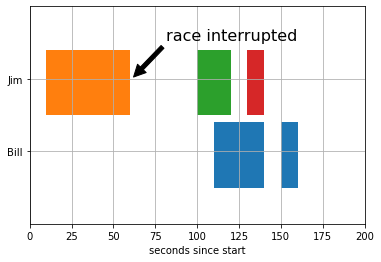

In [32]:

#===========
# Broken Barh
#===========

# Make a "broken" horizontal bar plot, i.e., one with gaps

import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots()
ax.broken_barh([(110, 30), (150, 10)], (10, 9), facecolors='tab:blue')
ax.broken_barh([(10, 50), (100, 20), (130, 10)], (20, 9), 
               facecolors=('tab:orange', 'tab:green', 'tab:red'))
ax.set_ylim(5, 35)
ax.set_xlim(0, 200)
ax.set_xlabel('seconds since start')
ax.set_yticks([15, 25])
ax.set_yticklabels(['Bill', 'Jim'])
ax.grid(True)
ax.annotate('race interrupted', (61, 25),
            xytext=(0.8, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')

plt.show()